In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import os
import requests
from collections import defaultdict
from scipy import interpolate
import csv
import pandas as pd
from scipy import integrate
from scipy.optimize import curve_fit, minimize
from astropy.cosmology import FlatLambdaCDM

## Reading in data from https://github.com/juliarobe/Galaxy_Morphology_Evolution:

In [2]:
sampleA = pd.read_csv('sampleA_proj1.csv')[:5000]
sampleB = pd.read_csv('sampleB_proj1.csv')[:5000]

## Part 1: Correcting for selection effects:
Clean data from csv files and pull in necessary variables to a DataFrame

In [3]:
data = pd.DataFrame()
mask = ~np.isnan(sampleA['z']) & ~np.isnan(sampleA['M_r'])
data['z'] = sampleA['z'][mask]
data['M_r'] = sampleA['M_r'][mask]
data['k_r'] = sampleA['k_r'][mask]
data['dL_pc'] = sampleA['d_L'][mask] #pc
data['dL_kpc'] = data['dL_pc'] / 1000.0
data['Re_pc'] = sampleA['r_eff_r_arc'][mask]
data['Re_kpc'] = data['Re_pc'] / 206265
data['m_corr'] = 17.5 - data['k_r'] + data['z'] * 1.3
data['Mlim'] = data['m_corr'] - 5*np.log10(data['dL_kpc']) - 25
data['m_app'] = sampleA['modelmag_r'][mask]
data['size_r'] = sampleA['size_r'][mask]
data['sb_r'] = sampleA['sb_r'][mask]

###  In https://github.com/juliarobe/Galaxy_Morphology_Evolution, I calculated m_corr and Mlim, so I go ahead and use those values. Then I match the galaxies based on their observed magnitudes being less than the absolute magnitude limit:

In [4]:
#matching galaxies based on observed mag being less than Mlim:
matched_gals = data[data['M_r'] <= data['Mlim']]

In [5]:
sizeR = sampleA['r_eff_r'][mask]*data['dL_pc']

### Using m_corr and Mlim to calculate the maximum luminosity distance at which a galaxy could be detected by the survey:

In [6]:
x = (data['m_corr'] - data['Mlim']) / 5
dL_lim_pc = (10 ** x) * 10**(1/5) #pc
dL_lim_kpc = dL_lim_pc / 1000 #kpc

### Finally can calculate the volume limit (V-max) using the maximum luminosity distance and the absolute magnitude limit:

In [7]:
Vlim = (4/3)*np.pi*(dL_lim_kpc**3)

### calculating the weight for each galaxy in the sample

In [8]:
weight = 1/Vlim
weight_norm = weight / np.sum(weight) / len(weight) 

### Refining V-max calculation:

In [9]:
# Define your cosmological model
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
z_arr = np.linspace(np.min(data['z']), np.max(data['z']), 4913)
Vlim_arr = np.linspace(np.min(Vlim), np.max(Vlim), 4913)

In [10]:
def M_lim(z, Q, k):
    mcorr = 17.5 - k + Q*z
    dL = cosmo.luminosity_distance(z).value
    return mcorr - 5*np.log10(dL*1000) - 25

### fit Q:
fit_Q calculates the volume limit using an interpolation function that takes the absolute magnitude values (M_r) and finds the closest values in Mlim to estimate the corresponding output values in V-max. The estimated output values are returned as Vlim_fit

The funtion fit_Q calculates the difference between V-max and Vlim_fit. Then, the value of Q is adjusted to minimize the difference between V-max and Vlim_fit

In [11]:
def fit_Q(Q):
    Mlim_fit = M_lim(z_arr, Q, data['k_r'].values)
    Vz_M_interpfit = interpolate.interp1d(Mlim_fit, Vlim_arr, bounds_error=False, fill_value='extrapolate')
    Vlim_fit = Vz_M_interpfit(data['M_r'].values)

    mask_fit = np.isnan(Vlim_fit)
    return np.abs(np.sum(Vlim_arr[~mask_fit] / Vlim_fit[~mask_fit]) - (len(data['M_r'].values[~mask_fit]) / 2))

In [12]:
# Minimize the function
result = minimize(fit_Q, 1.3)

# Optimal value of Q
optimal_Q = result.x[0]
print("Optimal Q:", optimal_Q)

Optimal Q: 1.3


**PLOTTING**

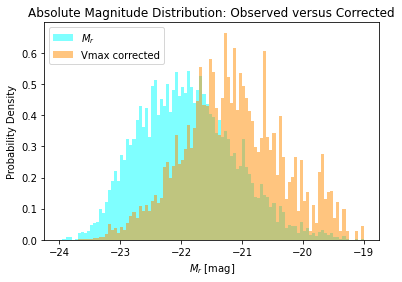

In [14]:
plt.hist(data["M_r"],bins=100,alpha=0.5,range = (-24, -19), label="$M_r$", color = 'cyan', density = True)
plt.hist(data["M_r"],weights = weight_norm, bins=100,alpha=0.5, range = (-24, -19), label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Absolute Magnitude Distribution: Observed versus Corrected")
plt.xlabel("$M_r$ [mag]")
plt.ylabel('Probability Density')
plt.legend()
#plt.savefig("abs_mag_dist_vmax.png")

In [15]:
sizeR = sampleA['r_eff_r'][mask]*data['dL_pc']
size_kpc = sizeR/1000

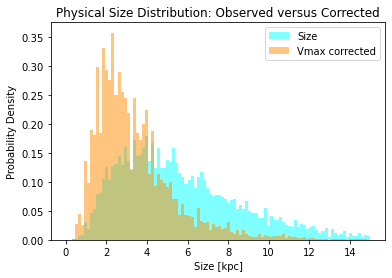

In [16]:
plt.hist(size_kpc,bins=100,alpha=0.5,range = (0,15), label="Size", color = 'cyan', density = True)
plt.hist(size_kpc,weights = weight_norm, bins=100,alpha=0.5, range = (0,15), label="Vmax corrected", color = 'darkorange', density = True)
plt.title("Physical Size Distribution: Observed versus Corrected")
plt.xlabel("Size [kpc]")
plt.ylabel('Probability Density')
plt.legend()
#plt.savefig("size_dist_vmax.png")

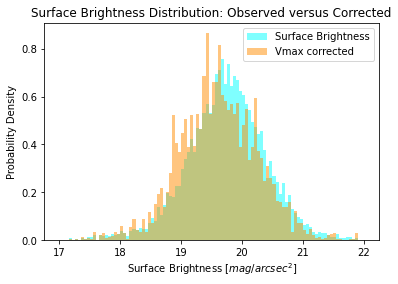

In [17]:
plt.hist(data['sb_r'],bins=100,alpha=0.5, range = (17,22), label="Surface Brightness", color = 'cyan', density = True)
plt.hist(data['sb_r'],weights = weight_norm, bins=100,alpha=0.5, range = (17,22), label="Vmax corrected", color = 'darkorange',density = True)
plt.title("Surface Brightness Distribution: Observed versus Corrected")
plt.xlabel("Surface Brightness [$mag/arcsec^2$]")
plt.ylabel('Probability Density')
plt.legend()
#plt.savefig("surf_brightness_dist_vmax.png")

## Part 2: Best Fit 1D Radial Surface Brightness Profiles

In [18]:
gal3 = pd.read_csv('gal3_linear.csv',sep="\s+",header=0)
gal10 = pd.read_csv('gal10_linear.csv', sep="\s+",header=0)
gal14 = pd.read_csv('gal14_linear.csv', sep="\s+",header=0)

In [19]:
def sersic_fit(R, R_e, mu_e, n):
    b = 1.999*n - 0.327
    mu = mu_e + (2.5*b/np.log(10))*((R/R_e)**(1/n) - 1)
    return mu

def dev_fit(R, R_e, mu_e):
    mu = mu_e + 8.327*((R/R_e)**0.25-1)
    return mu

def exp_fit(R, R_e, mu_e):
    mu = mu_e + (2.5*1.67/np.log(10))*((R/R_e) - 1)
    return mu

def dev_exp_fit(R, R_e, mu_dev ,mu_exp):
    return dev_fit(R, R_e, mu_dev) + exp_fit(R, R_e, mu_exp)

In [20]:
gal3x = gal3['#Rad[arcsec]'].values
gal3y = gal3['mu[mag/arcsec^2]'].values

gal10x = gal10['#Rad[arcsec]'].values
gal10y = gal10['mu[mag/arcsec^2]'].values

gal14x = gal14['#Rad[arcsec]'].values
gal14y = gal14['mu[mag/arcsec^2]'].values

### Model the radial surface brightness profiles using the deVaucouleurs, exponential, Sersic, and deVaucouleurs + exponential models:

In [21]:
params3_ser, _ = curve_fit(sersic_fit, gal3x, gal3y) #Re, mu_e, n
params3_dev, _ = curve_fit(dev_fit, gal3x, gal3y) #Re, mu_e
params3_exp, _ = curve_fit(exp_fit, gal3x, gal3y) #Re, mu_e
params3_devexp, _ = curve_fit(dev_exp_fit, gal3x, gal3y) #Re, mudev, muexp

In [22]:
params10_ser, _ = curve_fit(sersic_fit, gal3x, gal3y) #Re, mu_e, n
params10_dev, _ = curve_fit(dev_fit, gal3x, gal3y) #Re, mu_e
params10_exp, _ = curve_fit(exp_fit, gal3x, gal3y) #Re, mu_e
params10_devexp, _ = curve_fit(dev_exp_fit, gal3x, gal3y) #Re, mudev, muexp

In [23]:
params14_ser, _ = curve_fit(sersic_fit, gal3x, gal3y) #Re, mu_e, n
params14_dev, _ = curve_fit(dev_fit, gal3x, gal3y) #Re, mu_e
params14_exp, _ = curve_fit(exp_fit, gal3x, gal3y) #Re, mu_e
params14_devexp, _ = curve_fit(dev_exp_fit, gal3x, gal3y) #Re, mudev, muexp

### Calculating best-fit radial surface brightness profiles with the non-linear least squares method:

In [24]:
gal3y_serfit = sersic_fit(gal3x, *params3_ser)
res3ser = gal3y - gal3y_serfit

gal3y_devfit = dev_fit(gal3x, *params3_dev)
res3dev = gal3y - gal3y_devfit

gal3y_devexpfit = dev_exp_fit(gal3x, *params3_devexp)
res3devexp = gal3y - gal3y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res3ser**2)
sum_res_dev = np.sum(res3dev**2)
sum_res_devexp = np.sum(res3devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

Sersic Fit is the best.


### PLOTTING $\mu$ versus R with Sersic, de Vaucouleur and de Vaucouleur + exp profiles:

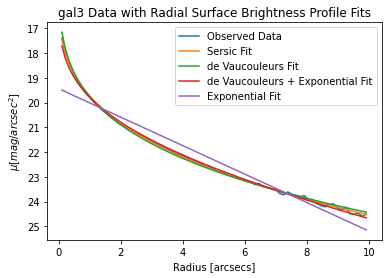

In [25]:
#gal3:
plt.plot(gal3x, gal3y, label='Observed Data')
plt.plot(gal3x, sersic_fit(gal3x, *params3_ser), label='Sersic Fit')
plt.plot(gal3x, dev_fit(gal3x, *params3_dev), label='de Vaucouleurs Fit')
plt.plot(gal3x, dev_exp_fit(gal3x, *params3_devexp), label='de Vaucouleurs + Exponential Fit')
plt.plot(gal3x, exp_fit(gal3x, *params3_exp), label='Exponential Fit')
plt.xlabel('Radius [arcsecs]')
plt.ylabel('$\mu [mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.title('gal3 Data with Radial Surface Brightness Profile Fits')
plt.legend()
#plt.savefig("gal3_R_vs_mu.png")
plt.show()

### Repeating for galaxy #10:

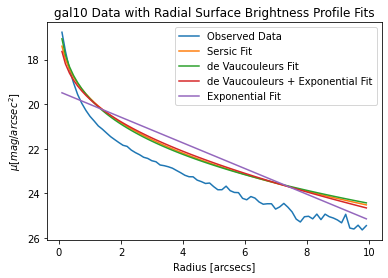

In [26]:
#gal10:
plt.plot(gal10x, gal10y, label='Observed Data')
plt.plot(gal10x, sersic_fit(gal10x, *params10_ser), label='Sersic Fit')
plt.plot(gal10x, dev_fit(gal10x, *params10_dev), label='de Vaucouleurs Fit')
plt.plot(gal10x, dev_exp_fit(gal10x, *params10_devexp), label='de Vaucouleurs + Exponential Fit')
plt.plot(gal10x, exp_fit(gal10x, *params10_exp), label='Exponential Fit')
plt.xlabel('Radius [arcsecs]')
plt.ylabel('$\mu [mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.title('gal10 Data with Radial Surface Brightness Profile Fits')
plt.legend()
#plt.savefig("gal10_R_vs_mu.png")
plt.show()

In [27]:
gal10y_serfit = sersic_fit(gal10x, *params10_ser)
res10ser = gal10y - gal10y_serfit

gal10y_devfit = dev_fit(gal10x, *params10_dev)
res10dev = gal10y - gal10y_devfit

gal10y_devexpfit = dev_exp_fit(gal10x, *params10_devexp)
res10devexp = gal10y - gal10y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res10ser**2)
sum_res_dev = np.sum(res10dev**2)
sum_res_devexp = np.sum(res10devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

DeVaucouleur Fit is the best.


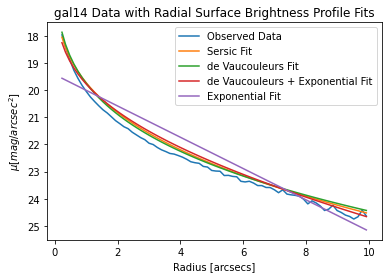

In [28]:
#gal14:
plt.plot(gal14x, gal14y, label='Observed Data')
plt.plot(gal14x, sersic_fit(gal14x, *params14_ser), label='Sersic Fit')
plt.plot(gal14x, dev_fit(gal14x, *params14_dev), label='de Vaucouleurs Fit')
plt.plot(gal14x, dev_exp_fit(gal14x, *params14_devexp), label='de Vaucouleurs + Exponential Fit')
plt.plot(gal14x, exp_fit(gal14x, *params14_exp), label='Exponential Fit')
plt.xlabel('Radius [arcsecs]')
plt.ylabel('$\mu [mag/arcsec^2]$')
plt.gca().invert_yaxis()
plt.title('gal14 Data with Radial Surface Brightness Profile Fits')
plt.legend()
#plt.savefig("gal14_R_vs_mu.png")
plt.show()

In [29]:
gal14y_serfit = sersic_fit(gal14x, *params14_ser)
res14ser = gal14y - gal14y_serfit

gal14y_devfit = dev_fit(gal14x, *params14_dev)
res14dev = gal14y - gal14y_devfit

gal14y_devexpfit = dev_exp_fit(gal14x, *params14_devexp)
res14devexp = gal14y - gal14y_devexpfit

# Calculate the sum of squared residuals
sum_res_ser = np.sum(res14ser**2)
sum_res_dev = np.sum(res14dev**2)
sum_res_devexp = np.sum(res14devexp**2)

# Find the fit with the minimal sum of squared residuals
best_fit = min(sum_res_ser, sum_res_dev, sum_res_devexp)

if best_fit == sum_res_ser:
    print("Sersic Fit is the best.")
elif best_fit == sum_res_dev:
    print("DeVaucouleur Fit is the best.")
else:
    print("DeVaucouleur + Exponential Fit is the best.")

DeVaucouleur Fit is the best.


*****************************************************************************************************

## Part 3: Concentration Index versus Redshift:

Going to select galaxies with similar luminosities, i.e. in small absolute magnitude bins (e.g. bin size=0.5mag), and plot ci versus redshift computing the median of ci in small redshift bins (delta z ~ 0.02).

In [32]:
import seaborn as sns

In [30]:
#Sample A:
#binning by magnitude and z:
sampleA['mag_bin'] = np.floor(sampleA['M_r'] / 0.5) * 0.5
sampleA['z_bin'] = np.floor(sampleA['z'] / 0.02) * 0.02

mag_bins_a = np.sort(np.unique(sampleA['mag_bin'][~np.isnan(sampleA['M_r'])]))[::-1]
z_bins_a = np.sort(np.unique(sampleA['z_bin'][~np.isnan(sampleA['z'])]))

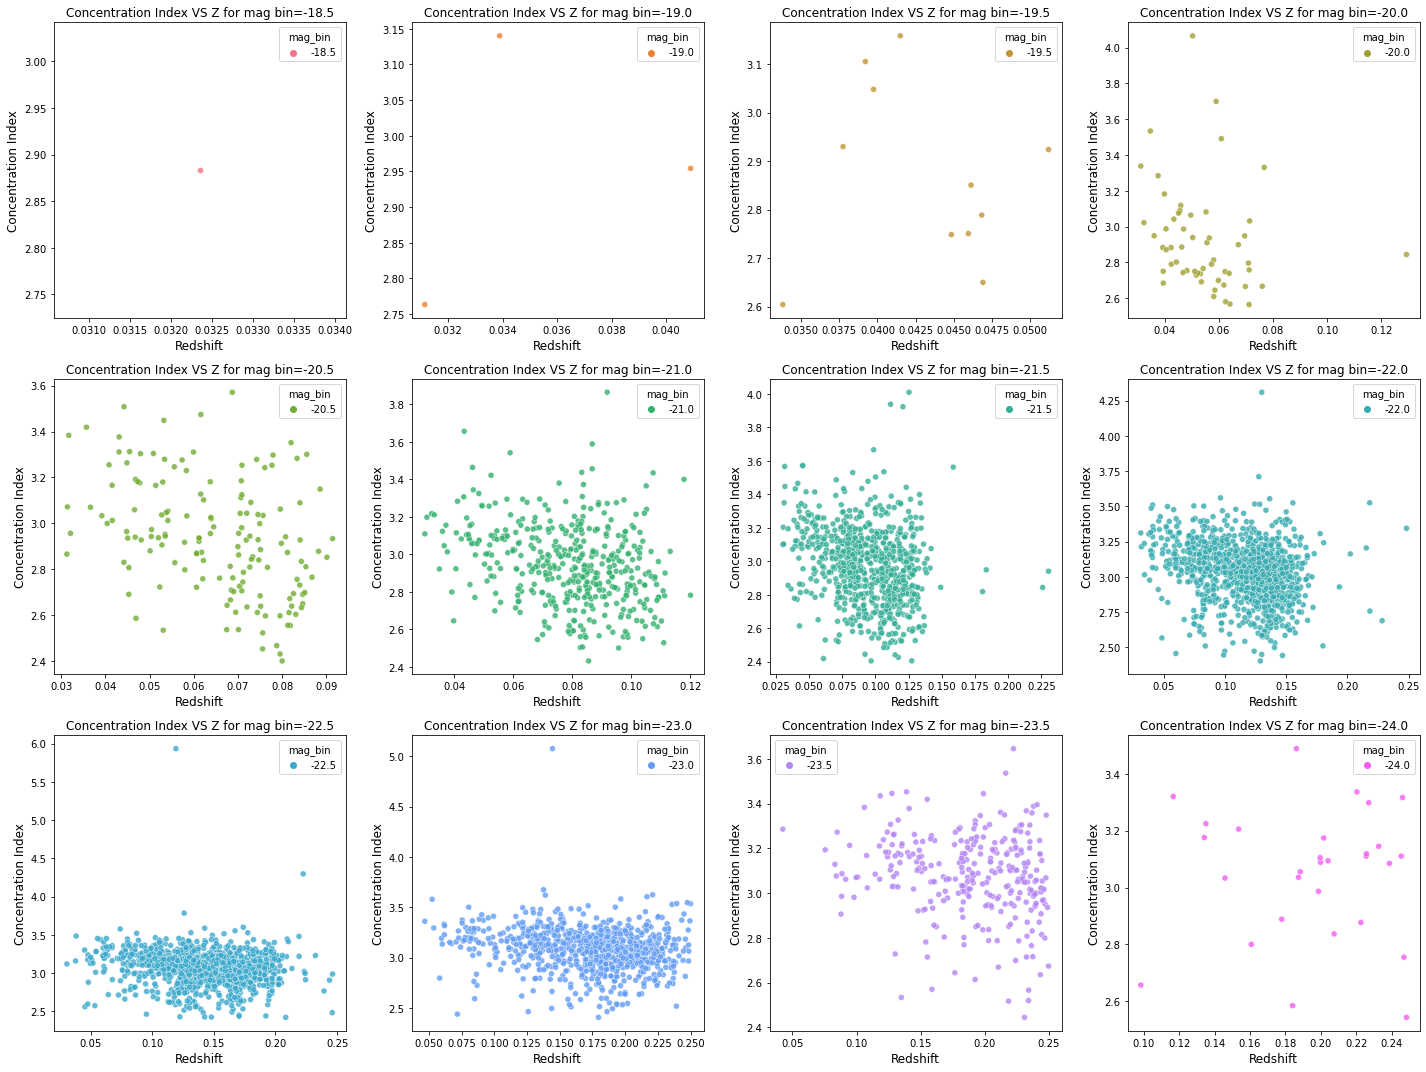

In [33]:
# Create a color palette with the number of unique magnitude bins
colors_a = sns.color_palette("husl", n_colors=len(mag_bins_a))

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_a, colors_a, axs.flatten()):
    # Select Galaxies in Specific Magnitude Bin
    group = sampleA[sampleA['mag_bin'] == mag_bin]

    # Check if the group is empty
    if not group.empty:
        # Plot 'ci' versus 'redshift'
        sns.scatterplot(data=group, x="z", y="concentration_index", hue="mag_bin", alpha=0.8, palette=[color], ax=ax)
        ax.set_xlabel("Redshift", fontsize=12)
        ax.set_ylabel("Concentration Index", fontsize=12)
        ax.set_title(f'Concentration Index VS Z for mag bin={mag_bin}', fontsize=12)

#plt.savefig("ci_vs_z_subplotsA.png")
plt.tight_layout()
plt.show()

In [34]:
# Create a color palette with the number of unique magnitude bins
colors_a = sns.color_palette("husl", n_colors=len(mag_bins_a))
ci_a = []
z_a = []

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_a, colors_a, axs.flatten()):
    ci_loop = []
    z_loop = []
    # Select Galaxies in Specific Magnitude Bin
    group = sampleA[sampleA['mag_bin'] == mag_bin]
    
    # Loop over each redshift bin within the magnitude bin
    for z_bin in z_bins_a:
        #z.append(z_bin)
        #Select Galaxies in Specific Redshift Bin within Magnitude Bin
        z_data = group[group['z_bin'] == z_bin]

        # Compute the Median of 'ci' in Redshift Bin
        ci_med = z_data['concentration_index'].median()
        ci_loop.append(ci_med)
        z_loop.append(z_bin)

    ci_a.append(ci_loop)
    z_a.append(z_loop)

In [35]:
ci_df_A = pd.DataFrame()

ci_df_A['z_bin'] = z_bins_a

# Iterate over the lists in ci
for idx, ci_list in enumerate(ci_a):
    ci_df_A['ci_med' + str(idx)] = ci_list

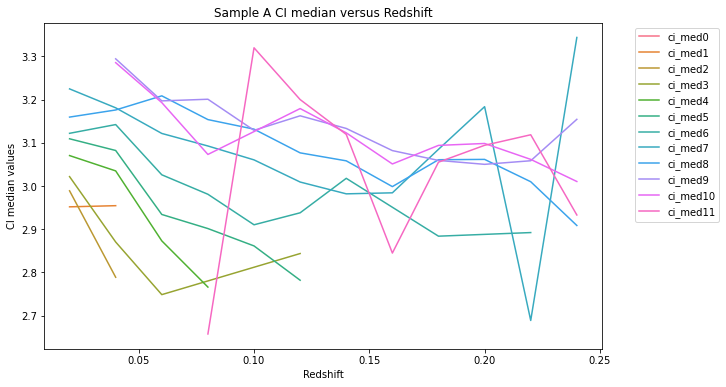

In [37]:
plt.figure(figsize=(10, 6))

# Melt the DataFrame
melted_A = pd.melt(ci_df_A, id_vars='z_bin', var_name='ci_medX', value_name='value')

# Plot using Seaborn
sns.lineplot(x='z_bin', y='value', hue='ci_medX', data=melted_A)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Redshift')
plt.ylabel('CI median values')
plt.title('Sample A CI median versus Redshift')
#plt.savefig("ci_vs_z_lineplotA.png")
plt.show()

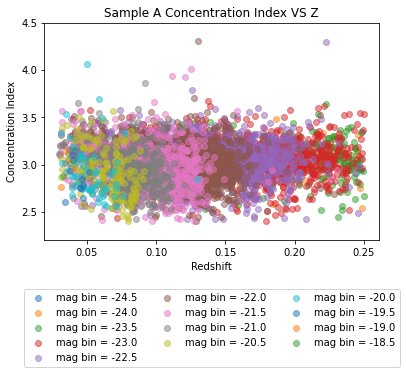

In [38]:
grouped_data = sampleA.groupby('mag_bin')
for label, group in grouped_data:
    plt.scatter(group['z'], group['concentration_index'], label=f'mag bin = {label}',alpha = 0.5)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.ylim(2.3,5.5)
plt.xlabel("Redshift")
plt.ylabel("Concentration Index")
plt.title(f'Sample A Concentration Index VS Z')
plt.ylim(2.2,4.5)

#plt.savefig("ci_vs_z_single_scatterA.png")

plt.show()

In [39]:
#Sample B:
#binning by magnitude and z:
sampleB['mag_bin'] = np.floor(sampleB['M_r'] / 0.5) * 0.5
sampleB['z_bin'] = np.floor(sampleB['z'] / 0.02) * 0.02

mag_bins_b = np.sort(np.unique(sampleB['mag_bin'][~np.isnan(sampleB['M_r'])]))[::-1]
z_bins_b = np.sort(np.unique(sampleB['z_bin'][~np.isnan(sampleB['z'])]))

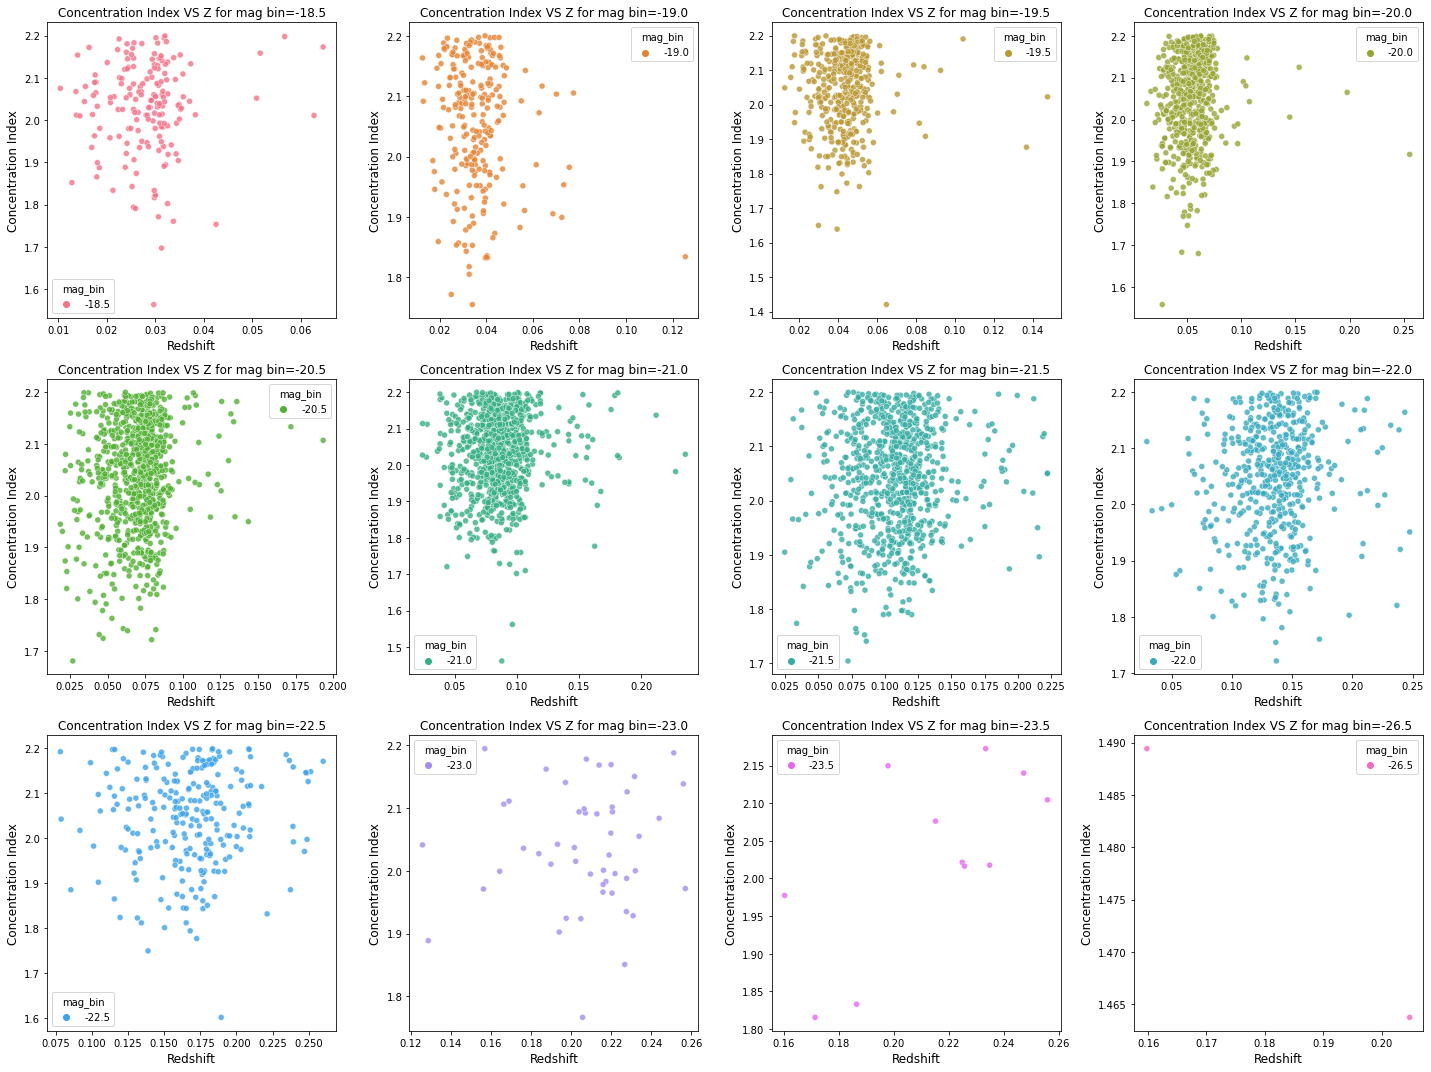

In [40]:
mag_bins_b = mag_bins_b[11:23]
# Create a color palette with the number of unique magnitude bins
colors_b = sns.color_palette("husl", n_colors=len(mag_bins_b))

# Create subplots
fig, axs = plt.subplots(3, 4, figsize=(20, 15))

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_b, colors_b, axs.flatten()):
    # Select Galaxies in Specific Magnitude Bin
    group = sampleB[sampleB['mag_bin'] == mag_bin]

    # Check if the group is empty
    if not group.empty:
        # Plot 'ci' versus 'redshift'
        sns.scatterplot(data=group, x="z", y="concentration_index", hue="mag_bin", alpha=0.8, palette=[color], ax=ax)
        ax.set_xlabel("Redshift", fontsize=12)
        ax.set_ylabel("Concentration Index", fontsize=12)
        ax.set_title(f'Concentration Index VS Z for mag bin={mag_bin}', fontsize=12)

#plt.savefig("ci_vs_z_subplotsB.png")

plt.tight_layout()
plt.show()

In [41]:
# Create a color palette with the number of unique magnitude bins
colors_b = sns.color_palette("husl", n_colors=len(mag_bins_b))
ci_b = []
z_b = []

# Loop over each magnitude bin
for mag_bin, color, ax in zip(mag_bins_b, colors_b, axs.flatten()):
    ci_loop = []
    z_loop = []
    # Select Galaxies in Specific Magnitude Bin
    group = sampleB[sampleB['mag_bin'] == mag_bin]
    
    # Loop over each redshift bin within the magnitude bin
    for z_bin in z_bins_b:
        #z.append(z_bin)
        #Select Galaxies in Specific Redshift Bin within Magnitude Bin
        z_data = group[group['z_bin'] == z_bin]

        # Compute the Median of 'ci' in Redshift Bin
        ci_med = z_data['concentration_index'].median()
        ci_loop.append(ci_med)
        z_loop.append(z_bin)

    ci_b.append(ci_loop)
    z_b.append(z_loop)

In [42]:
ci_df_b = pd.DataFrame()

ci_df_b['z_bin'] = z_bins_b

# Iterate over the lists in ci
for idx, ci_list in enumerate(ci_b):
    ci_df_b['ci_med' + str(idx)] = ci_list

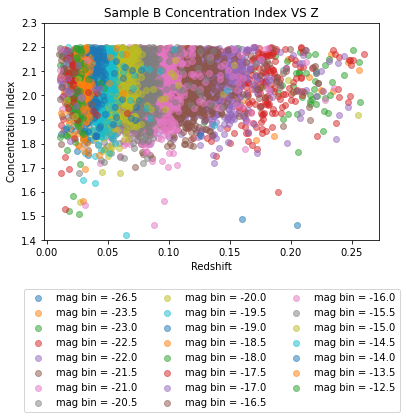

In [43]:
grouped_data = sampleB.groupby('mag_bin')
for label, group in grouped_data:
    plt.scatter(group['z'], group['concentration_index'], label=f'mag bin = {label}',alpha = 0.5)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
#plt.ylim(2.3,5.5)
plt.xlabel("Redshift")
plt.ylabel("Concentration Index")
plt.title(f'Sample B Concentration Index VS Z')
plt.ylim(1.4,2.3)

#plt.savefig("ci_vs_z_single_scatterB.png")

plt.show()

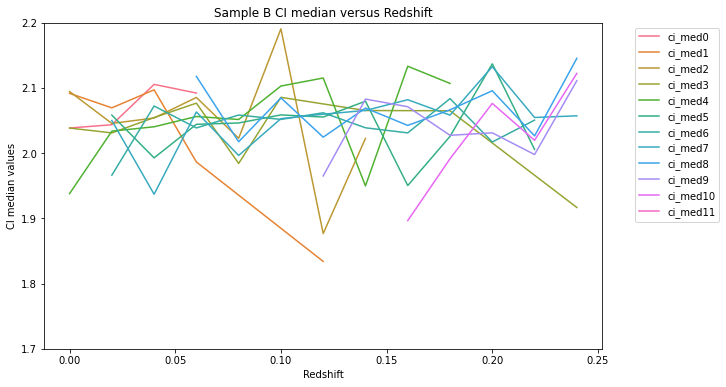

In [44]:
# Replace df with your DataFrame
plt.figure(figsize=(10, 6))

# Melt the DataFrame
melted_B = pd.melt(ci_df_b, id_vars='z_bin', var_name='ci_medX', value_name='value')

# Plot using Seaborn
sns.lineplot(x='z_bin', y='value', hue='ci_medX', data=melted_B)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(1.7, 2.2)
plt.xlabel('Redshift')
plt.ylabel('CI median values')
plt.title('Sample B CI median versus Redshift')
#plt.savefig("ci_vs_z_lineplotB.png")
plt.show()

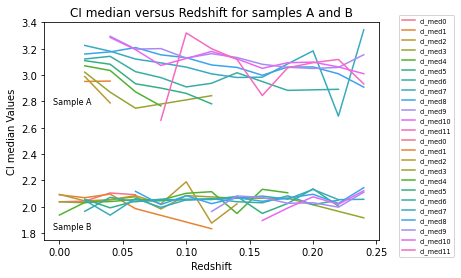

In [45]:
#plotting both sample A and B:

# Melt the DataFrames and reset index
melted_A = pd.melt(ci_df_A, id_vars='z_bin', var_name='ci_medX', value_name='value').reset_index()
melted_B = pd.melt(ci_df_b, id_vars='z_bin', var_name='ci_medX', value_name='value').reset_index()

# Add a prefix to ci_medX column based on the source DataFrame
melted_A = melted_A.add_prefix('A_')
melted_B = melted_B.add_prefix('B_')

# Combine the melted DataFrames
combined_df = pd.concat([melted_A, melted_B])

# Plot the combined data
sns.lineplot(x='A_z_bin', y='A_value', hue='A_ci_medX', data=combined_df)
sns.lineplot(x='B_z_bin', y='B_value', hue='B_ci_medX', data=combined_df)

plt.legend(bbox_to_anchor=(1.05, 1.05), loc='upper left', fontsize=6.5)

# Add text to the plot
plt.text(0.01, 2.80, 'Sample A', fontsize=8, ha='center', va='center')#, transform=plt.gca().transAxes)
plt.text(0.01, 1.85, 'Sample B', fontsize=8, ha='center', va='center')#, transform=plt.gca().transAxes)

plt.xlabel('Redshift')
plt.ylabel('CI median Values')
plt.ylim(1.75,3.4)
plt.title('CI median versus Redshift for samples A and B')

#plt.savefig("ci_vs_z_lineplotAandB.png")
plt.show()

*******************************************************************************************************

## Part 4: Median Radius versus Evolution Corrected Absolute Magnitude:

I compute the median radius in both the r-band and the g-band in small bins of the evolution corrected r-band absolute magnitudes. Then, I plot the difference of the median values versus the evolution corrected r-band absolute magnitude.

In [46]:
sampleA['devRkpc_r'] = sampleA['devrad_r'] / 206265
sampleA['devRkpc_g'] = sampleA['devrad_g'] / 206265
sampleA['ev_corr_absMr'] = sampleA['M_r'] + 0.9 * sampleA['z']

sampleA['evcorr_bin'] = np.floor(sampleA['ev_corr_absMr'] / 0.5) * 0.5

evcorr_bins = np.sort(np.unique(sampleA['evcorr_bin'][~np.isnan(sampleA['ev_corr_absMr'])]))[::-1]

**Computing median radii:**

In [47]:
med_dev_r = []
med_dev_g = []
for bin in evcorr_bins:
    group = sampleA[sampleA['evcorr_bin'] == bin]
    med_devRkpc_r = group['devRkpc_r'].median()
    med_dev_r.append(med_devRkpc_r)
    
    med_devRkpc_g = group['devRkpc_g'].median()
    med_dev_g.append(med_devRkpc_g)

In [48]:
med_r = np.array(med_dev_r)
med_g = np.array(med_dev_g)
diff = med_g - med_r

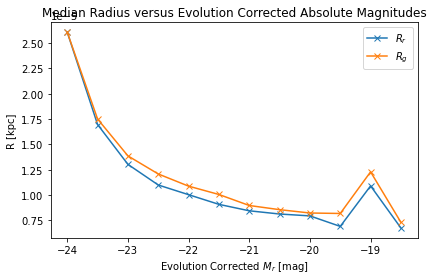

In [49]:
plt.plot(evcorr_bins, med_r, label = '$R_r$', marker = 'x')
plt.plot(evcorr_bins, med_g, label = '$R_g$', marker = 'x')
plt.xlabel('Evolution Corrected $M_r$ [mag]')
plt.ylabel('R [kpc]')
plt.title('Median Radius versus Evolution Corrected Absolute Magnitudes')
plt.legend()
plt.tight_layout()
#plt.savefig('Rg_Rr_vs_evolcorr_Mr.png')
plt.show()

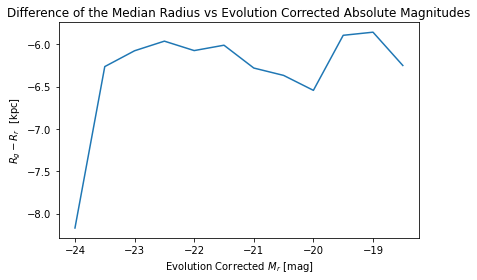

In [50]:
diff_format = np.log10(np.abs(diff))
plt.plot(evcorr_bins, diff_format)
plt.xlabel('Evolution Corrected $M_r$ [mag]')
plt.ylabel('$R_g - R_r$  [kpc]')
plt.title('Difference of the Median Radius vs Evolution Corrected Absolute Magnitudes')
plt.tight_layout()
#plt.savefig('med_R_vs_evolcorr_Mr.png')
plt.show()